In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('ggplot')
import random
from random import randint
import math
import h5py

In [23]:
food_amount = 20
pacman_amount = 50
board_size = 1000
default_health = 1500
pacmen = [] # global array of all the pacmen
food = [] # '' of the food
crot = 1 #cost of rotation
cloc = .0005 # cost of locamotion
cbite = 1 #cost of bite
turn_loss = 1000 # loss each turn (starvation factor)
phi_prec = (80/255.) # params used for binary genes, this is field of view ex out of 80 degrees
alpha_prec = 10/255. # not implemented, but is angular error
delta_prec = 10/255. #error for depth
pacman_radius = 1 # raduis for the bite to be sucessful
food_health = 3000 # health gained from a sucessful bite
mutation_freq = .15 # percent any 0/1 would flip for each gene
generations = 500 # num of gens
turns = 200 #num of turns in each gen

In [24]:
class pacman: # class of pacman has everything needed, including multple properly
    def __init__(self):
        #change dynamically
        self.x = random.uniform(49*board_size/100,51*board_size/100)
        self.y = random.uniform(49*board_size/100,51*board_size/100)
        #this is set so the prgression will be outward
        self.theta = randint(0,359)
        self.health = default_health
        self.active = 1
        #dna
        self.phi = randint(0,255) # field of view
        self.alpha = randint(0,255) #angle error
        self.delta = randint(0,255) # depth error
        
        self.phi_val = self.phi*phi_prec # converts binary to a float 
        self.alpha_val = self.alpha*alpha_prec
        self.delta_val = self.delta*delta_prec
        #self.f = closest food
        #self.dist = closest food distance
    def __bool__(self):
        return True
    
    def __repr__(self):
        #return "{pacman, x:"+str(self.x)+", y:"+str(self.y)+", theta:"+str(self.theta)+"}"
        return str(self.health)+"|"+str(self.phi_val)
    
    def find_dist(self,f):
        return np.sqrt((self.x-f.x)**2 + (self.y-f.y)**2)
    
    def find_angle(self,f):
        dx = f.x - self.x
        dy = f.y - self.y
        arc = math.degrees(math.atan((dy/dx)))
        theta1 = 1
        if dx > 0:
            theta1 = 180 - arc
            #this used to be an if, but i think arctan returns a negative when a negative is inputted.
            #therefor the two would be equivalent
        else:
            if dy > 0:
                theta1 = np.absolute(arc)
                #this is absolute because the angle will be a negative
            else:
                theta1 = 360 - arc
        #theta1 is the angle the food is from the x axis
        #returned is the difference in the angles
        return np.absolute(theta1 - self.theta)
    
    def check_angle(self,f):#check if the food is in the range
        diff = (self.phi_val/2)#this creates virutal bounds
        f_angle = self.find_angle(f)
        if(f_angle < diff):
            return True
        return False
        
    def find_food(self):
        global food
        closest = False
        closest_dist = False
        for i in food:
            dist = self.find_dist(i)
            if((dist < closest_dist or not closest_dist) and (self.check_angle(i))):
                closest = i
                closest_dist = dist
            self.f = closest
            self.dist = closest_dist
        if(closest != False):
            return True
        return False
        
    def rotate_to_food(self):# returns (in radians!!!) the angle needed to get the food with genetic error
        #no cost to rotation
        dx =  self.f.x - self.x
        dy =  self.f.y - self.y
        arc = math.atan((dy/dx))
        error = random.uniform(self.alpha_val/-2., self.alpha_val/2.)
        new_theta = arc + error
        return new_theta 
        
    def get_food(self):
        theta = self.rotate_to_food() #warning this is in radians...
        #theta is not used... 
        
        error = random.uniform(self.delta_val/-2., self.delta_val/2.)
        new_dist = self.dist + (error*self.dist)
        #the error for distance is relative to the distance, ie the greater the dist the greater the error
        
        dx =  self.f.x - self.x
        dy =  self.f.y - self.y
        distx = new_dist*(dx/self.dist)#equivalent to cos, error is not associted with the angle yet
        disty = new_dist*(dy/self.dist)#equivalent to sin
        self.x += distx
        self.y += disty
        cost = cloc*new_dist
        self.health -= cost
        #cost of rotate
    
    def bite(self):
        to_food = self.find_dist(self.f)
        self.health -= cbite
        if(to_food < pacman_radius):#means the bite was sucessful
            self.health += food_health
            self.f.reset()
        self.check_bounds()
    def check_bounds(self):
        if(self.x > board_size or self.x < 0):
            self.x = self.x % board_size
        #if(self.x < 0):
        # self.x = board_size + self.x
        if(self.y > board_size or self.y < 0):
            self.y = self.y % board_size
            
            
    
    def random_rotate(self):
        self.theta = randint(0,359)
        #self.health += randint(-2,1)
    
    def step(self):
        self.health -= turn_loss
        if(self.find_food()):
            self.get_food()
            self.bite()
        self.random_rotate()
    
    
    def get_genes(self):
        return[self.phi,self.alpha,self.delta]
    
    def set_genes(self,genes):
        self.phi = genes[0]
        self.alpha = genes[1]
        self.delta = genes[2]
        
    def to_bits(self):
        genes = self.get_genes()
        split_genes = []
        for i in genes:
            bin_str = format(i, '#010b')
            bin_str = bin_str[2:]
            split_genes.append([bin_str[:4],bin_str[4:]])
        return split_genes
    def mutate(self, gene):
        #checks each 1/0 and finds a random num and if it below the threshold it mutates
        new_gene = ''
        for i in gene:
            rand = random.uniform(0,1)
            if(rand < mutation_freq):
                #this means the dna is flipping
                num = int(i)
                if(num == 1):
                    num = 0
                else:
                    num = 1
                new_gene += str(num)
            else:
                new_gene += str(i)
                
        return new_gene
        
        
    def reproduce(self,other):
        son1 = pacman()
        son2 = pacman()
        son1_genes = []
        son2_genes = []
        mybits = self.to_bits()
        otherbits = other.to_bits()
        for i,v in enumerate(mybits):
            son1_gene = v[0]+otherbits[i][1]
            son1_gene = self.mutate(son1_gene)
            son2_gene = otherbits[i][0]+v[1]
            son2_gene = self.mutate(son2_gene)
            son1_gene = int('0b'+son1_gene,base=2)
            son2_gene = int('0b'+son2_gene,base=2)
            son1_genes.append(son1_gene)
            son2_genes.append(son2_gene)
        son1.set_genes(son1_genes)
        son2.set_genes(son2_genes)
        return [son1,son2]


In [25]:
class dot:
    def __init__(self):
        self.x = random.uniform(0, board_size)
        self.y = random.uniform(0, board_size)
        self.active = 1
    def __repr__(self):
        return "{dot, x:"+str(self.x)+", y:"+str(self.y)+"}"
    def reset(self):
        self.x = random.uniform(0, board_size)
        self.y = random.uniform(0, board_size)

In [26]:
def gen1():
    global pacmen
    pacmen = []
    for i in range(0,pacman_amount):
        p = pacman()
        pacmen.append(p)
    pacmen = np.array(pacmen)
    pac_data = []
    for d,v in enumerate(pacmen):
        pac_data.append([])
        pac_data[d].append(v.x)
        pac_data[d].append(v.y)
        pac_data[d].append(v.theta)
        pac_data[d].append(v.health)
        pac_data[d].append(v.phi_val)
        pac_data[d].append(v.delta_val)
    #pac_turn_data_first.append(pac_data)
    return pacmen

def food1():
    global food
    food = []
    for i in range(0,food_amount):
        f = dot()
        food.append(f)
    food = np.array(food)
    return food

def reproduce1(healthy_pacmen):# takes an array of pacmen and reproduces each with a neibor
    #inactive for now
    sons = []
    for i,v in enumerate(healthy_pacmen):
        if( i % 2 == 1):
            temp = v.reproduce(healthy_pacmen[randint(0,len(healthy_pacmen)-1)])
            sons.extend(temp)
    return sons

def find_average_health(p,x=10): #takes an array of pacmen and finds the averge health
    #it will also sort the pacemen by health and return the helath of the xth pacman
    pacmen_ranked = []
    avg_health = 0
    for i in p:
        pacmen_ranked.append(i.health)
        avg_health += i.health
        
    avg_health = avg_health/len(p)
    pacmen_ranked = np.array(sorted(pacmen_ranked))
    med_health = pacmen_ranked[x]
    #print(avg_health, med_health)
    return avg_health, med_health

def reproduce2(healthy_pacmen, x):# takes an array of pacmen and reproduces randomly with other heathy_pacmen
    # x is how many are cut off in the evolution
    sons = []
    total = int(len(healthy_pacmen)/2) + int(x/2) + 1
    for i in range(0,total):
        rand1 = randint(0,len(healthy_pacmen)-1)
        rand2 = randint(0,len(healthy_pacmen)-1)
        p1 = healthy_pacmen[rand1]
        p2 = healthy_pacmen[rand2]
        temp = p1.reproduce(p2)
        sons.extend(temp)
                        
    return sons

def reproduce3(healthy_pacmen):
    myscale = len(pacmen)/2
    sons = []
    total = int(len(pacmen)/2)
    for i in range(0,total):
        rand1 = np.random.exponential(scale=myscale)
        rand2 = np.random.exponential(scale=myscale)
        
        while rand1 > len(pacmen) - 1:
            rand1 = np.random.exponential(scale=myscale)
        while rand2 > len(pacmen) - 1:
            rand2 = np.random.exponential(scale=myscale)
        rand1 = int(rand1/2)
        rand2 = int(rand2/2)
        #print(rand1,rand2)
        p1 = healthy_pacmen[rand1]
        p2 = healthy_pacmen[rand2]
        temp = p1.reproduce(p2)
        sons.extend(temp)
    return sons
    
def average_genes(p):#phi alpha delta
    avg1 = 0
    avg2 = 0
    avg3 = 0
    for i in p:
        avg1 += i.phi_val
        avg2 += i.alpha_val
        avg3 += i.delta_val
    avg1 = avg1/len(p)
    avg2 = avg2/len(p)
    avg3 = avg3/len(p)
    return avg1,avg2,avg3

def bubbleSort(unranked):
    for passnum in range(len(unranked)-1,0,-1):
        for i in range(passnum):
            if unranked[i].health>unranked[i+1].health:
                temp = unranked[i]
                unranked[i] = unranked[i+1]
                unranked[i+1] = temp



In [27]:
def driver(gen,life_span,generations):
    food = food1()
    dt = 1
    t = [0]
    tracker = []
    genetics = [[],[],[]]
    cycles = []
    
    global pacmen
    
    for g in range(0,generations): #iterates through each generation
        tracker.append([])
        avg1,avg2,avg3 = average_genes(pacmen)
        genetics[0].append(avg1)
        genetics[1].append(avg2)
        genetics[2].append(avg3)
        for i in pacmen:
            tracker[g].append([])
            
        cycles.append([])
        t.append(t[-1]+dt)
        for q in range(0,life_span): #runs through time with current generation
            for i,v in enumerate(pacmen):
                tracker[g][i].append([v.x,v.y,v.theta,v.health,v.phi,v.delta])
                v.step()
            cycles[g].append([])# note cycles starts after the first gen
            cycles[g][q].append([])
            cycles[g][q].append([])
            cycles[g][q].append([])
            cycles[g][q].append([])
            for w in pacmen:
                cycles[g][q][0].append(w.x)
                cycles[g][q][1].append(w.y)
            for f in food:
                cycles[g][q][2].append(f.x)
                cycles[g][q][3].append(f.y)
                
        
        
        #makes the next generation
        #x = 150 # number of pacmen dieing
        #healthy_pacmen = []
        #avg,med = find_average_health(pacmen,x)
        
        #for i,v in enumerate(pacmen): #end of a generation mean reproduce
                #if(v.health > med):
                    #healthy_pacmen.append(v)
        #this system kills off the bottom x pacmen
        unranked = pacmen
        bubbleSort(unranked)
        ranked = unranked[::-1]
        #print(ranked)
        sons = reproduce3(ranked)
      
        pacmen = sons
        # if it is the last gen it will save the data
        if(g == generations - 1):           
            genN_file = h5py.File("genN.h5","w") # the first argument is the filename, second says we're allowing writes ("w"). Read only is "r".
            genN_file['/genN'] = tracker[generations-1]
            genN_file.close()
            
            
            gen1_file = h5py.File("gen1.h5","w") # the first argument is the filename, second says we're allowing writes ("w"). Read only is "r".
            gen1_file['/gen1'] = tracker[0]
            gen1_file.close()
        
    return t,tracker,genetics,cycles

In [28]:
t,tracker,genetics,cycles = driver(gen1(),turns,generations)#turns then generations

<IPython.core.display.Javascript object>


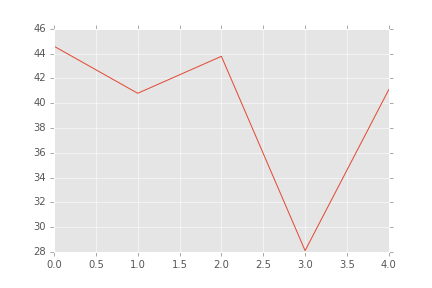

In [14]:
#remember to check both params out
plt.figure()
plt.plot(genetics[0])# should increase
#plt.plot(genetics[1])#should decrease
#plt.plot(genetics[2])#should decrease
# error is disabled

In [ ]:
tracker = np.array(tracker)
figs = 8
gen = 0
f, axarr = plt.subplots(figs, sharex=True,sharey=True)
for i in range(0,figs):
    axarr[i].scatter(cycles[gen][i][0],cycles[gen][i][1])
    axarr[i].scatter(cycles[gen][i][2],cycles[gen][i][3], marker='^',c='red')
    


In [ ]:
infile = h5py.File("gen1.h5", "r")
data_from_disk = infile['/gen1'][:]
infile.close()
print(data_from_disk)
print('next!!!!')
infile = h5py.File("genN.h5", "r")
data_from_disk = infile['/genN'][:]
infile.close()
print(data_from_disk)